In [1]:
# import necesary modules
import numpy as np
import pickle
import tqdm
import data.data_util as util
from preprocessing import parse_labels, partition_data, augment_data, load_bci_competition, load_data
import matplotlib.pyplot as plt

In [21]:
# load in the data
data_fname = 'JN_movement_w_feedback_0_replay'  # name of the data file

fpath = "data/" + data_fname
eeg_data = util.load_data(fpath + "/eeg.bin")      # reads EEG data
eeg_data['databuffer'] = eeg_data['databuffer'][:, 0:64]  # removes channels 65 and 66
task_data = util.load_data(fpath + "/task.bin")# reads task data

## Extract Trials

In [22]:
# extract trial start times
new_state_bool = np.zeros(task_data['state_task'].size, dtype='bool')
new_state_bool[1:] = (task_data['state_task'][1:] != task_data['state_task'][:-1])
new_state_inds = np.nonzero(new_state_bool)[0]
trial_labels = task_data['state_task'][new_state_inds]
trial_start_times = task_data['time_ns'][new_state_inds] 
eeg_timing = eeg_data['time_ns']
task_timing = task_data['time_ns']

In [23]:
# partition trials
eeg_trials = []; eeg_trial_labels = []; decoder_trials = []
min_trial_len = 0



class_names={}
class_names[0] = "left"
class_names[1] = "right"
class_names[4] = "rest"
for trial_ix in range(len(trial_labels)-7):  # last seven trials don't exist in EEG data
    if int(trial_labels[trial_ix]) == 4:  # skip rest trials
        continue 

    # extract eeg_data indices were trial started and ended
    trial_start_ix = np.where(eeg_timing > trial_start_times[trial_ix])[0][0]
    trial_end_ix = np.where(eeg_timing < trial_start_times[trial_ix+1])[0][-1]

    # append data from 64 electrodes
    eeg_trials.append(eeg_data['databuffer'][trial_start_ix:trial_end_ix, :64])
    min_trial_len = np.minimum(eeg_trials[-1].shape[0], min_trial_len).astype(int)
    eeg_trial_labels.append(class_names[trial_labels[trial_ix]])

    # extract eeg_data indices were each decoder trial started and ended
    trial_start_ix = np.where(task_timing > trial_start_times[trial_ix])[0][0]
    trial_end_ix = np.where(task_timing < trial_start_times[trial_ix+1])[0][-1]

    # append data from 64 electrodes
    decoder_trials.append(task_data['decoded_pos'][trial_start_ix:trial_end_ix, 0])  # 0 only considers x position




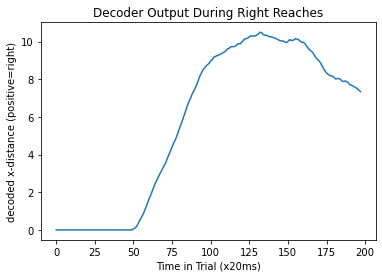

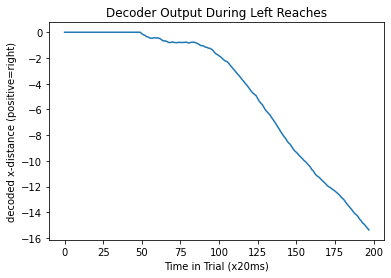

In [24]:
decoded_pos = decoder_trials
decoded_pos = np.array(decoded_pos)
decoded_right = decoded_pos[np.array(eeg_trial_labels)=='right']
decoded_left = decoded_pos[np.array(eeg_trial_labels)=='left']

plt.figure()
plt.plot(np.mean(decoded_right, axis=0))
plt.xlabel("Time in Trial (x20ms)")
plt.ylabel("decoded x-distance (positive=right)")
plt.title("Decoder Output During Right Reaches")

plt.figure()
plt.plot(np.mean(decoded_left, axis=0))
plt.xlabel("Time in Trial (x20ms)")
plt.ylabel("decoded x-distance (positive=right)")
plt.title("Decoder Output During Left Reaches")
plt.show()